<a href="https://colab.research.google.com/github/roysa-msft/tech-train-reusable-modules/blob/main/ERM_Ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from pprint import pprint

### Background

In this exercise we will compute an ERM hypothesis for the same prediction problem mentioned in class, but each time with different assumptions (and slightly different training set). We will see that finding an ERM hypothesis isn't always computationally easy, and experience first hand the impact of the Approximation Error (in calss we called it $appx$).

You are given various tables, each of which contains, $n=10^6$ softness levels and their corresponding labels (1 = tasty, 0 = otherwise). Each table is a csv file you can load with `pd.read_csv()`.
Recall that softness is encoded as a floating number between 0 and 1.

For this exercise we will use the zero-one loss, which doesn't discriminate between types of error.

#### Baseline predictor

A learning rule is an algorithm $A$ that is given a training set $S$ and return $h\in\cal{H}$ (recall that $\cal{H}$ is implied by the algorithm).

Let's start with the basics.
Your goal is to find a learning rule $A$ that has the following properties:
* It is applicable for **any** binary classification task, which means $\cal{H}=\{x\in\cal{X}\mapsto\{0,1\}\}$ works for any the feature space $\cal{X}$
* It is very simple to compute (specifically, a signle pass over the dataset is suffice)
* The resulting $h$ always have $\cal{L}_{S}(h)\le\frac12$ (with respect to the zero-one loss).

We will call the corresponding hypothesis $h$ the "baseline" hypothesis.

Implement such a learning rule, and apply it to the given dataset to compute the "baseline" $\theta$.

Hint: if the algorithm should work for any feature space, it means that it doesn't look at the features at all.

<Axes: xlabel='x', ylabel='label'>

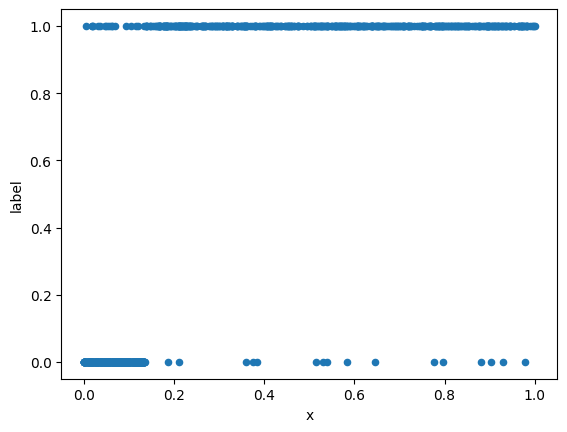

In [20]:
df1 = pd.read_csv('s1ex1.csv')
df1.head()

df1.sample(n=1_000).plot.scatter(x='x', y='label')

In [21]:
def baseline_hypothesis(df):
    """ The function should return a callback which accepts a single float and return zero or one """
    return lambda z: z > 0.3

def training_error(df, h):
    return (df['label'] != df['x'].map(h)).mean()

print('Empirical loss of the baseline hypothesis is:', training_error(df1, baseline_hypothesis(df1)))

real_threshold = (1 / np.e) ** 2
print('Note that the OPTIMAL threshold is', real_threshold, "with error:", training_error(df1, lambda x: 1 if x >= real_threshold else 0), "and the error is not zero because the data was generated with noise.")

Empirical loss of the baseline hypothesis is: 0.12743
Note that the OPTIMAL threshold is 0.1353352832366127 with error: 0.040046 and the error is not zero because the data was generated with noise.


#### Efficient ERM requires strong prior knowledge

Suppose our hypothesis space is the 1 dimensional threshold functions, as showed in class, which is parametrized by a threshold $\theta$ and a direction $b\in\{{\pm1}\}$ .
Find an ERM hypothesis, e.g. the best threshold $\theta$ and direction $b$, **efficiently** for the dataset `s1ex1.csv`, by running a binary search over the interval $[0,1]$.

In order to do that you'll have to figure out:
* What is the stopping criterion for the search?
* How to choose to which side (e.g. right or left) of the $x$ axis to "drill in" with the recursion?

Note that there is no one "right" answer here.

You are encouraged to manually explore the dataset, here are some suggestions:
* Plot the label as a function of $x$: `df.sample(n=10000).plot.scatter(x='x', y='label')`
* Display the training error as a function of the threshold, by manually selecting threshold candidates, e.g.: `np.linspace(0, 1.0)`

In [ ]:
def to_label_stats(df):
    return df['label'].value_counts().reindex([0,1]).fillna(0)

def threshold_split_stats(left_counts, right_counts):
    errs_if_left_equal_zero = left_counts[1] + right_counts[0]
    errs_if_left_equal_one = left_counts[0] + right_counts[1]

    best_left_label = int(errs_if_left_equal_one < errs_if_left_equal_zero)

    left = {
        'label': best_left_label,
        'size': left_counts[0] + left_counts[1],
        'mistakes': left_counts[1-best_left_label]
    }

    right = {
        'label': 1 - best_left_label,
        'size': right_counts[0] + right_counts[1],
        'mistakes': right_counts[best_left_label]
    }

    return left, right


def evaluate_single_threshold(df, threshold):
    left_mask = df['x'] < threshold

    left_counts = to_label_stats(df.loc[left_mask])
    right_counts = to_label_stats(df.loc[~left_mask])

    left_segment, right_segment = threshold_split_stats(left_counts, right_counts)

    return {
        'thr': threshold,
        'left': left_segment,
        'right': right_segment,
        'total_mistakes': left_segment['mistakes'] + right_segment['mistakes']
    }

def calc_stats_for_multiple_thresholds(df, thresholds=np.linspace(0, 1)):
    thresholds = pd.Series(thresholds, name='thr')
    mistakes = thresholds.map(lambda t: evaluate_single_threshold(df, t)['total_mistakes'])
    loss_df = pd.DataFrame({'thr': thresholds, 'total_mistakes': mistakes})
    return loss_df

loss1 = calc_stats_for_multiple_thresholds(df1)
loss1.plot.line(x='thr', y='total_mistakes')

In [ ]:
def binary_search_erm(df):
    """ The function should return a callback which accepts a single float and return zero or one """
    pass

h_binary_search1 = binary_search_erm(df1)
print(
    'Real threshold:', real_threshold, '\n',
    'empirical error:', training_error(df1, h_binary_search1)
)

#### Failure example

Unfortunately, if we aren't careful, our algorithm might fail. To see this, run your code for the file `s2ex2.csv`.

Which threshold our learning algorithm returned? Is it the right one? You can see the "best" threshold by plotting the error as a function of selected theta-candidates.

In [ ]:
# evaluate on s2ex2.csv
df2 = pd.read_csv('s1ex2.csv')
df2.head()

In [ ]:
loss2 = calc_stats_for_multiple_thresholds(df2)
loss2.plot.line(x='thr', y='total_mistakes')

In [ ]:
h_binary_search2 = binary_search_erm(df2)
print(
    'Real threshold:', real_threshold, '\n',
    'empirical error:', training_error(df2, h_binary_search2)
)

#### Implement Exhaustive search for ERM hypothesis

Why the algorithm failed? Understanding the root cause is critical. In particular, this means that using a binary search over the threshols is NOT a successful PAC learner.

Without strong prior knowledge about the underline data-generation process, we can't apply the same trick of binary bisection (as we did with the first dataset). In most cases, we'll have to check all possible threshold **which are relevant** for the given training data (this was a hint).

Putting it differently, now we have to check $\cal{O}(n)$ thresholds (rather than $\cal{O}(\log_2{n})$. In practice, sometimes we check only a random subset of the relevant thresholds, this speed up the running time but decrease the quality of the estimation.

Write an exhaustive search for the ERM hypothesis and show that it succeed to find a better predictor on `s1ex2.csv`.

In [ ]:
# Implement exhaustive search for ERM over thresholds.

In [ ]:
def threshold_erm_exhaustive(df):
    """ The function should return a callback which accepts a single float and return zero or one """
    pass

exhaustive_erm1 = threshold_erm_exhaustive(df1)

print(
    'Real threshold:', real_threshold, '\n',
    'empirical error:', training_error(df1, exhaustive_erm1)
)

In [ ]:
exhaustive_erm2 = threshold_erm_exhaustive(df2)

print(
    'Real threshold:', real_threshold, '\n',
    'empirical error:', training_error(df2, exhaustive_erm2)
)

#### Approximation Error

Lastly, we will try to use the exhaustive threshold search over a new training set (same prediction task), named `s1ex3.csv`.

Find the optimal threshold $\theta$ and direction $b$, and then compute the empirical risk of that predictor.

Hint: it can be useful to generate two plots: the line of the empirical loss of various candidates over the range $[0,1]$, and the data itself (as a scatter plot).

In [ ]:
# Explore the dataset, then run the ERM exhaustive search
# to find the best threshold function and compute its empirical risk.
df3 = pd.read_csv('s1ex3.csv')
df3.head()

In [ ]:
exhaustive_erm3 = threshold_erm_exhaustive(df3)

print(
    'empirical error:', training_error(df3, exhaustive_erm2)
)

In [ ]:
loss3 = calc_stats_for_multiple_thresholds(df3)
loss3.plot.line(x='thr', y='total_mistakes')

In [ ]:
df3.sample(n=500).plot.scatter(x='x', y='label')

What is the empirical risk of the threshold classifier? What is the inherent limitation of our prediction algorithm?

Note that the empirical risk can be lower than 0.05, see in the next cell such a predicor (it also give a hint for the questions in the previous line)

In [ ]:
def segments_predictor(x):
    if 0.2 <= x <= 0.6:
        return 1
    if 0.85 <= x:
        return 1
    return 0

print('empirical error:', training_error(df3, segments_predictor))

We need a way to split the real-line into multiple (i.e. more than 2) segments. We will get back to this in session 3, where both the segments' boundaries and the number of segments will be derived from the data-itself.

Find below a toy algorithm for finding a greedy partition to a given (!) number of segments. You can run it with multiple values for `num_segments` and see the results for yourself.

In [ ]:
def intervals_split_err(left_counts, right_counts):
    # predicting majority within each side, means the total num mistakes is the minorities combined
    return min(left_counts) + min(right_counts)

def intervals_split_stats(left_counts, right_counts):
    def predict_majority_stats(counts):
        majority_label = 1 if counts[1] > counts[0] else 0
        return {
            'label': majority_label,
            'size': counts[0] + counts[1],
            'mistakes': counts[1 - majority_label]
        }

    left = predict_majority_stats(left_counts)
    right = predict_majority_stats(right_counts)

    return left, right

def erm_for_segments(df, num_segments, split_err_func, split_stats_func, start=0.0, end=1.0):

    def find_segment_to_split(segments):
        key, _ = max(segments.items(), key = lambda k_v: k_v[1]['mistakes'])
        return key

    df_fragment = df

    df_stats = to_label_stats(df)
    segments = {
        (start, end): {'label': df_stats.argmax(), 'size': len(df), 'mistakes': df_stats.min()}
    }

    while len(segments) < num_segments:
        segment_key_to_split = find_segment_to_split(segments)

        if segments[segment_key_to_split]['mistakes'] == 0:
            break

        relevant_df_fragment = df.loc[df['x'].between(*segment_key_to_split)].sort_values('x')
        curr_split = suggest_best_split(relevant_df_fragment, split_err_func, split_stats_func)

        # new left and right segments:
        segments[(segment_key_to_split[0], curr_split['thr'])] = curr_split['left']
        segments[(curr_split['thr'], segment_key_to_split[1])] = curr_split['right']


        del segments[segment_key_to_split]

    return segments


res_segmenst = erm_for_segments(df3,
                            num_segments=4,
                            split_err_func=intervals_split_err,
                            split_stats_func=intervals_split_stats)
print('result:')
pprint(res_segmenst)
